# Case 1 (Part I): House price prediction

In this case (Part I), we will build a multilayer perceptron network to predict the selling price of properties. The dataset consists of all single family houses and condos that were sold in Denver in a given year.

---
## Data Loading and Visualize Data

You first need to read the data using pandas.

In [2]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis

data_path_train = "https://www.dropbox.com/scl/fi/p5wqzhzorpg2a9qq7o2on/train.csv?rlkey=nq3r3wug3ul1j6bylm2njb2dk&dl=1"

train_df = pd.read_csv(data_path_train)

In [3]:
print(train_df)

           ID                          NBHD               PROP_CLASS  \
0      454754                     MONTCLAIR             CONDOMINIUMS   
1      190773                      HIGHLAND  SINGLE FAMILY RESIDENCE   
2      159143                   ATHMAR PARK  SINGLE FAMILY RESIDENCE   
3      110649                     MONTCLAIR  SINGLE FAMILY RESIDENCE   
4      694203  GATEWAY / GREEN VALLEY RANCH  SINGLE FAMILY RESIDENCE   
...       ...                           ...                      ...   
11576    6526                     RUBY HILL  SINGLE FAMILY RESIDENCE   
11577  420264                    UNIVERSITY  SINGLE FAMILY RESIDENCE   
11578  380716                   FIVE POINTS             CONDOMINIUMS   
11579   83737  GATEWAY / GREEN VALLEY RANCH  SINGLE FAMILY RESIDENCE   
11580  441854                SOUTHMOOR PARK  SINGLE FAMILY RESIDENCE   

       LIVING_SQFT  FBSMT_SQFT  BSMT_AREA  LAND_SQFT  GRD_AREA  BLDG_AGE  \
0              928           0          0          0       

### Visualization of SALE PRICES in train data

Let's take a closer look at the sale prices in the train data.

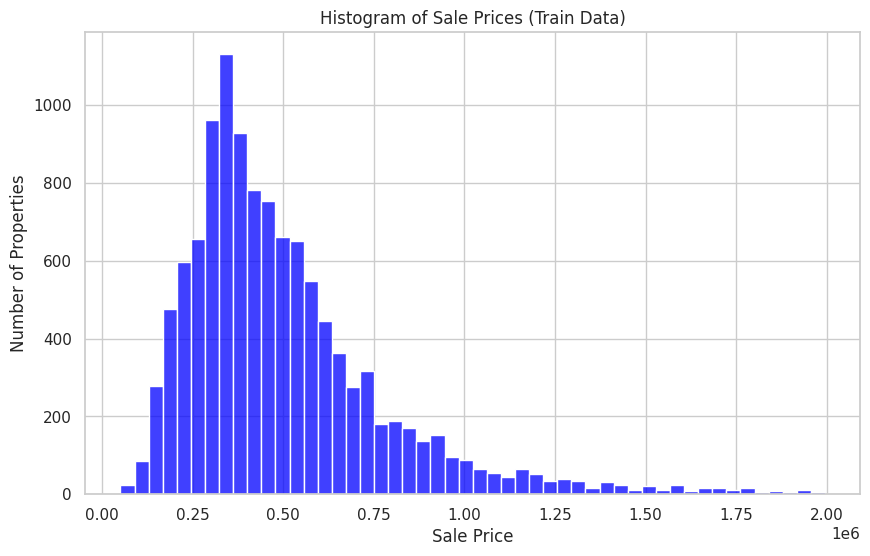

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- **Train labels**: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. **Note**: We need to ensure that the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [5]:
#define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

In [6]:
train_labels.shape

(11581,)

The column ID does not contain any useful information so we drop it from our data file.

In [7]:
train_ID=train_df['ID']
train_df.drop('ID', axis=1, inplace=True)

In [8]:
# find out which are numerical features
numeric_features = train_df.dtypes[train_df.dtypes != 'object'].index
non_numeric_features = train_df.dtypes[train_df.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

In [9]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    train_features= train_df.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    train_features = pd.get_dummies(train_df, columns=non_numeric_features, dummy_na=False)

# Check for non-numeric columns
non_numeric_cols = train_features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [10]:
#impute missing values in numeric features with 0
train_features[numeric_features]=train_features[numeric_features].fillna(0)


In [11]:
train_features.shape

(11581, 102)

In [12]:
#standardize the features

import numpy as np
train_mu = train_features.mean()
train_sd = train_features.std()



In [13]:
train_features_std=((train_features - train_mu)/(train_sd))

#drop columns with NA values
train_features_std=train_features_std.dropna(axis='columns')

In [14]:
# check whether there is any missing entry; we ended up with 102 variables
print(train_features_std.isnull().sum())

LIVING_SQFT               0
FBSMT_SQFT                0
BSMT_AREA                 0
LAND_SQFT                 0
GRD_AREA                  0
                         ..
STYLE_CN_MIDDLE UNIT      0
STYLE_CN_RANCH            0
STYLE_CN_SPLIT LEVEL      0
STYLE_CN_TRI-LEVEL        0
STYLE_CN_TRI-LEVEL W/B    0
Length: 102, dtype: int64


---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [15]:
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set
# Splitting the training data: 20% is validation data
train_indices, valid_indices, train_features, valid_features, train_labels, valid_labels = train_test_split(
    np.arange(len(train_labels)),
    train_features_std,
    train_labels,
    test_size=0.2,
    random_state=42
)

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model.

We need to think about what loss function and what metric for evaluating predictive performance to use.

*  We will be using the mean absolute error loss for training loss.
*  We will use a different metric to measure the predictive performance.


Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we error by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

In [36]:
# we need to define our own error rate function.

import tensorflow as tf
import tensorflow_probability as tfp

def median_error_rate(y_true, y_pred):
 # Calculate the absolute percentage error
    absolute_percentage_error = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true),
                                                                            tf.keras.backend.epsilon(),
                                                                            tf.float32.max))
    # Return the median of these errors
    return tfp.stats.percentile(absolute_percentage_error, 50.0)  # Use 50th percentile for median


In [39]:
# Build a multi-layer perception neural network with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations

import keras

import keras

# Define the learning rates, epochs, and batch sizes to try
learning_rates = [0.05, 0.03, 0.05, 0.01, 0.01]
epochs_list = [40, 50, 50, 70, 50]
batch_sizes = [50, 50, 30, 50, 50]

# Create an empty list to store the results
results = []

p = train_features_std.shape[1]
print(p)

# Build the MLP
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(256, input_shape=(p,), activation="ReLU"))
model1.add(keras.layers.Dense(128, activation="ReLU"))
model1.add(keras.layers.Dense(1, activation="linear"))

# Display the model's architecture
model1.summary()



102
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               26368     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 59393 (232.00 KB)
Trainable params: 59393 (232.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# Create empty lists to store the training and validation errors for each run
train_errors_list1 = []
val_errors_list1 = []

# Iterate over the combinations of learning rates, epochs, and batch sizes
for lr, epochs, batch_size in zip(learning_rates, epochs_list, batch_sizes):
    # Compile the model with the current learning rate
    model1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                   loss="mae", metrics=[median_error_rate])

    # Train the model with the current epochs and batch size
    history1 = model1.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size,
                         validation_data=(valid_features, valid_labels))

    # Evaluate the model on the validation data
    val_loss, val_error = model1.evaluate(valid_features, valid_labels)

    # Get the training and validation errors for each epoch
    train_errors = history.history['median_error_rate']
    val_errors = history.history['val_median_error_rate']

    # Append the training and validation errors to the respective lists
    train_errors_list1.append(train_errors)
    val_errors_list1.append(val_errors)

    # Append the results to the list
    results.append([lr, epochs, batch_size, train_errors[-1], val_error])

Epoch 1/40
186/186 [==============================] - 2s 4ms/step - loss: 1.6465 - median_error_rate: 0.2698 - val_loss: 1.2331 - val_median_error_rate: 0.1801
Epoch 2/40
186/186 [==============================] - 1s 3ms/step - loss: 1.0488 - median_error_rate: 0.1472 - val_loss: 1.0053 - val_median_error_rate: 0.1350
Epoch 3/40
186/186 [==============================] - 1s 3ms/step - loss: 0.9795 - median_error_rate: 0.1364 - val_loss: 0.9419 - val_median_error_rate: 0.1291
Epoch 4/40
186/186 [==============================] - 1s 3ms/step - loss: 0.9856 - median_error_rate: 0.1362 - val_loss: 0.9478 - val_median_error_rate: 0.1230
Epoch 5/40
186/186 [==============================] - 1s 3ms/step - loss: 1.0136 - median_error_rate: 0.1434 - val_loss: 1.0984 - val_median_error_rate: 0.1564
Epoch 6/40
186/186 [==============================] - 1s 4ms/step - loss: 0.9557 - median_error_rate: 0.1321 - val_loss: 0.9378 - val_median_error_rate: 0.1270
Epoch 7/40
186/186 [====================

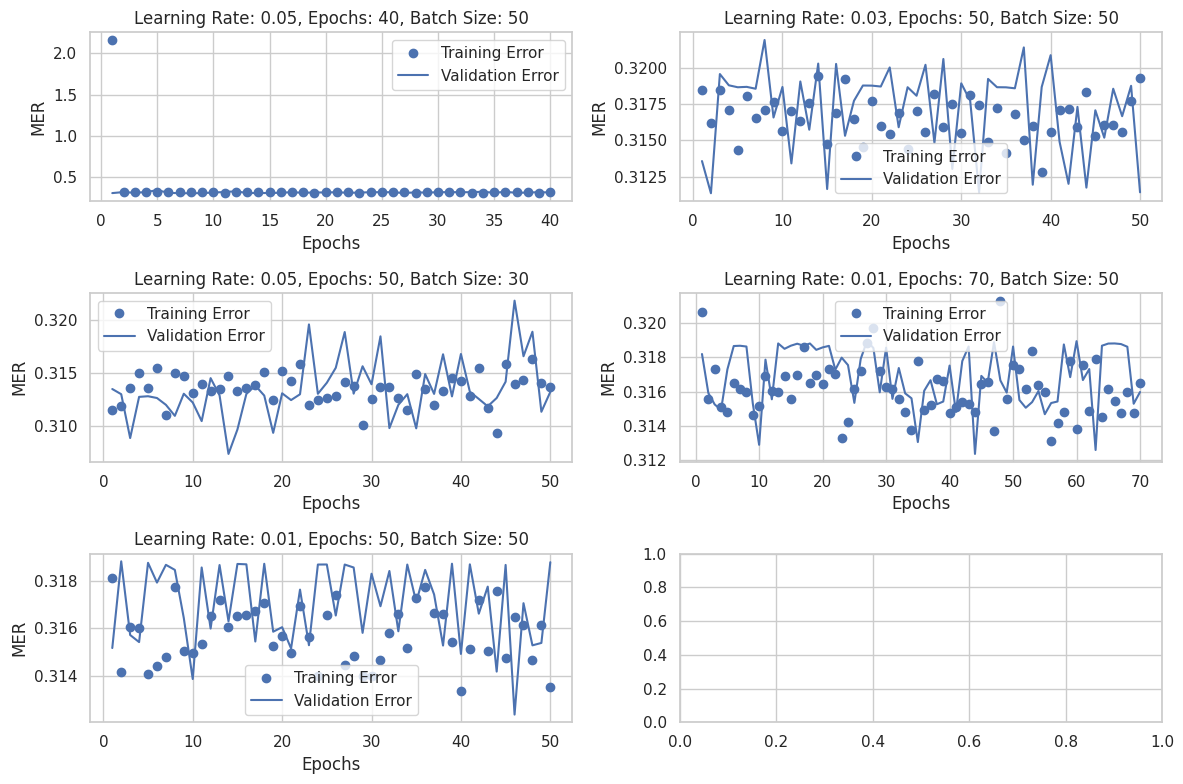

In [30]:
# plot the training error (MER) over epochs
import matplotlib.pyplot as plt

# Create a figure with four subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

# Plot the training and validation errors for each hyperparameter combination
for i, (train_errors, val_errors, result) in enumerate(zip(train_errors_list1, val_errors_list1, results)):
    ax = axs[i]
    epochs = range(1, len(train_errors) + 1)

    ax.plot(epochs, train_errors, 'bo', label='Training Error')
    ax.plot(epochs, val_errors, 'b', label='Validation Error')

    ax.set_title(f"Learning Rate: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MER")
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

**Question 1**: What are your final training and validation errors of the multilayer perception model?


In [25]:
# Print the results
print("Learning Rate | Epochs | Batch Size | Train Error | Validation Error")
print("----------------------------------------------------------------")
for result in results:
    print(f"{result[0]:.3f}         | {result[1]:6d} | {result[2]:10d} | {result[3]:.4f}      | {result[4]:.4f}")

Learning Rate | Epochs | Batch Size | Train Error | Validation Error
----------------------------------------------------------------
0.050         |     40 |         50 | 0.1202      | 0.1653
0.030         |     50 |         50 | 0.0827      | 0.1055
0.050         |     50 |         30 | 0.1168      | 0.1286
0.010         |     70 |         50 | 0.0726      | 0.1005
0.010         |     50 |         50 | 0.0710      | 0.1046


**Now change the model structure**

In [26]:
#Build a multi-layer perception neural network with 4 hidden layers of sizes 512, 256, 128 and 64, respectively and ReLu activations

# Define the learning rates, epochs, and batch sizes to try
learning_rates = [0.05, 0.03, 0.05, 0.01, 0.01]
epochs_list = [40, 50, 50, 70, 50]
batch_sizes = [50, 50, 30, 50, 50]

# Create an empty list to store the results
results = []
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(512, input_shape=(p,), activation="ReLU"))
model2.add(keras.layers.Dense(256, activation="ReLU"))
model2.add(keras.layers.Dense(128, activation="ReLU"))
model2.add(keras.layers.Dense(64, activation="ReLU"))
model2.add(keras.layers.Dense(1, activation="linear"))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               52736     
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 225281 (880.00 KB)
Trainable params: 225281 (880.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# code to train the MLP network
# Create empty lists to store the training and validation errors for each run
train_errors_list = []
val_errors_list = []

# Iterate over the combinations of learning rates, epochs, and batch sizes
for lr, epochs, batch_size in zip(learning_rates, epochs_list, batch_sizes):
    # Compile the model with the current learning rate
    model2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                   loss="mae", metrics=[median_error_rate])

    # Train the model with the current epochs and batch size
    history2 = model2.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size,
                         validation_data=(valid_features, valid_labels))

    # Evaluate the model on the validation data
    val_loss, val_error = model2.evaluate(valid_features, valid_labels)

    # Get the training and validation errors for each epoch
    train_errors = history2.history['median_error_rate']
    val_errors = history2.history['val_median_error_rate']

    # Append the training and validation errors to the respective lists
    train_errors_list.append(train_errors)
    val_errors_list.append(val_errors)

    # Append the results to the list
    results.append([lr, epochs, batch_size, train_errors[-1], val_error])

Epoch 1/40
186/186 [==============================] - 2s 6ms/step - loss: 9.8933 - median_error_rate: 2.1591 - val_loss: 1.9959 - val_median_error_rate: 0.3079
Epoch 2/40
186/186 [==============================] - 1s 5ms/step - loss: 1.9815 - median_error_rate: 0.3173 - val_loss: 1.9946 - val_median_error_rate: 0.3203
Epoch 3/40
186/186 [==============================] - 1s 5ms/step - loss: 1.9826 - median_error_rate: 0.3172 - val_loss: 1.9924 - val_median_error_rate: 0.3114
Epoch 4/40
186/186 [==============================] - 1s 5ms/step - loss: 1.9834 - median_error_rate: 0.3188 - val_loss: 1.9944 - val_median_error_rate: 0.3201
Epoch 5/40
186/186 [==============================] - 1s 5ms/step - loss: 1.9844 - median_error_rate: 0.3171 - val_loss: 2.0221 - val_median_error_rate: 0.3433
Epoch 6/40
186/186 [==============================] - 1s 6ms/step - loss: 1.9860 - median_error_rate: 0.3172 - val_loss: 1.9920 - val_median_error_rate: 0.3115
Epoch 7/40
186/186 [====================

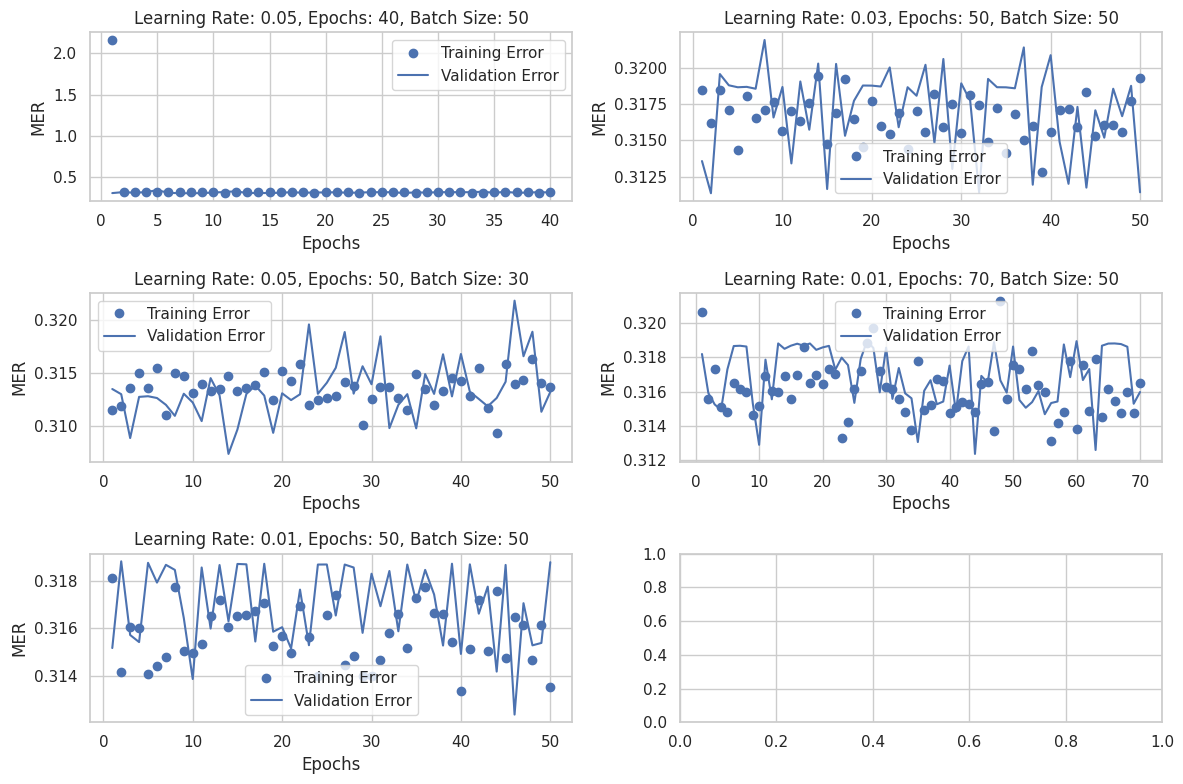

In [29]:
# code to plot the training error (MER) over epochs
import matplotlib.pyplot as plt

# Create a figure with four subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

# Plot the training and validation errors for each hyperparameter combination
for i, (train_errors, val_errors, result) in enumerate(zip(train_errors_list, val_errors_list, results)):
    ax = axs[i]
    epochs = range(1, len(train_errors) + 1)

    ax.plot(epochs, train_errors, 'bo', label='Training Error')
    ax.plot(epochs, val_errors, 'b', label='Validation Error')

    ax.set_title(f"Learning Rate: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MER")
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


 final training and validation errors of the second multilayer perception model

In [31]:
# Print the results
print("Learning Rate | Epochs | Batch Size | Train Error | Validation Error")
print("----------------------------------------------------------------")
for result in results:
    print(f"{result[0]:.3f}         | {result[1]:6d} | {result[2]:10d} | {result[3]:.4f}      | {result[4]:.4f}")

Learning Rate | Epochs | Batch Size | Train Error | Validation Error
----------------------------------------------------------------
0.050         |     40 |         50 | 0.3178      | 0.3298
0.030         |     50 |         50 | 0.3193      | 0.3274
0.050         |     50 |         30 | 0.3137      | 0.3357
0.010         |     70 |         50 | 0.3165      | 0.3299
0.010         |     50 |         50 | 0.3135      | 0.3349


**Now a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64 and drop out**

In [32]:
# Build a multi-layer perception neural network with 4 hidden layers of sizes 512, 256, 128 and 64, respectively and ReLu activations

model3 = keras.models.Sequential()
model3.add(keras.layers.Dense(512, input_shape=(p,), activation="relu"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(256, activation="relu"))
model3.add(keras.layers.Dropout(0.2))
model3.add(keras.layers.Dense(128, activation="relu"))
model3.add(keras.layers.Dense(64, activation="relu"))
model3.add(keras.layers.Dense(1, activation="linear"))
## display the model's architecture
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               52736     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 1)                

In [33]:
#code to train the MLP network
# Create empty lists to store the training and validation errors for each run
train_errors_list = []
val_errors_list = []

# Iterate over the combinations of learning rates, epochs, and batch sizes
for lr, epochs, batch_size in zip(learning_rates, epochs_list, batch_sizes):
    # Compile the model with the current learning rate
    model3.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                   loss="mae", metrics=[median_error_rate])

    # Train the model with the current epochs and batch size
    history = model3.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size,
                         validation_data=(valid_features, valid_labels))

    # Evaluate the model on the validation data
    val_loss, val_error = model3.evaluate(valid_features, valid_labels)

    # Get the training and validation errors for each epoch
    train_errors = history.history['median_error_rate']
    val_errors = history.history['val_median_error_rate']

    # Append the training and validation errors to the respective lists
    train_errors_list.append(train_errors)
    val_errors_list.append(val_errors)

    # Append the results to the list
    results.append([lr, epochs, batch_size, train_errors[-1], val_error])

Epoch 1/40
186/186 [==============================] - 6s 15ms/step - loss: 4.8820 - median_error_rate: 0.9403 - val_loss: 1.9915 - val_median_error_rate: 0.3129
Epoch 2/40
186/186 [==============================] - 1s 8ms/step - loss: 1.9931 - median_error_rate: 0.3209 - val_loss: 1.9939 - val_median_error_rate: 0.3195
Epoch 3/40
186/186 [==============================] - 2s 11ms/step - loss: 1.9913 - median_error_rate: 0.3222 - val_loss: 1.9913 - val_median_error_rate: 0.3171
Epoch 4/40
186/186 [==============================] - 1s 6ms/step - loss: 1.9868 - median_error_rate: 0.3189 - val_loss: 1.9969 - val_median_error_rate: 0.3073
Epoch 5/40
186/186 [==============================] - 1s 6ms/step - loss: 1.9837 - median_error_rate: 0.3182 - val_loss: 2.0122 - val_median_error_rate: 0.3354
Epoch 6/40
186/186 [==============================] - 1s 7ms/step - loss: 1.9782 - median_error_rate: 0.3168 - val_loss: 2.0049 - val_median_error_rate: 0.3063
Epoch 7/40
186/186 [==================

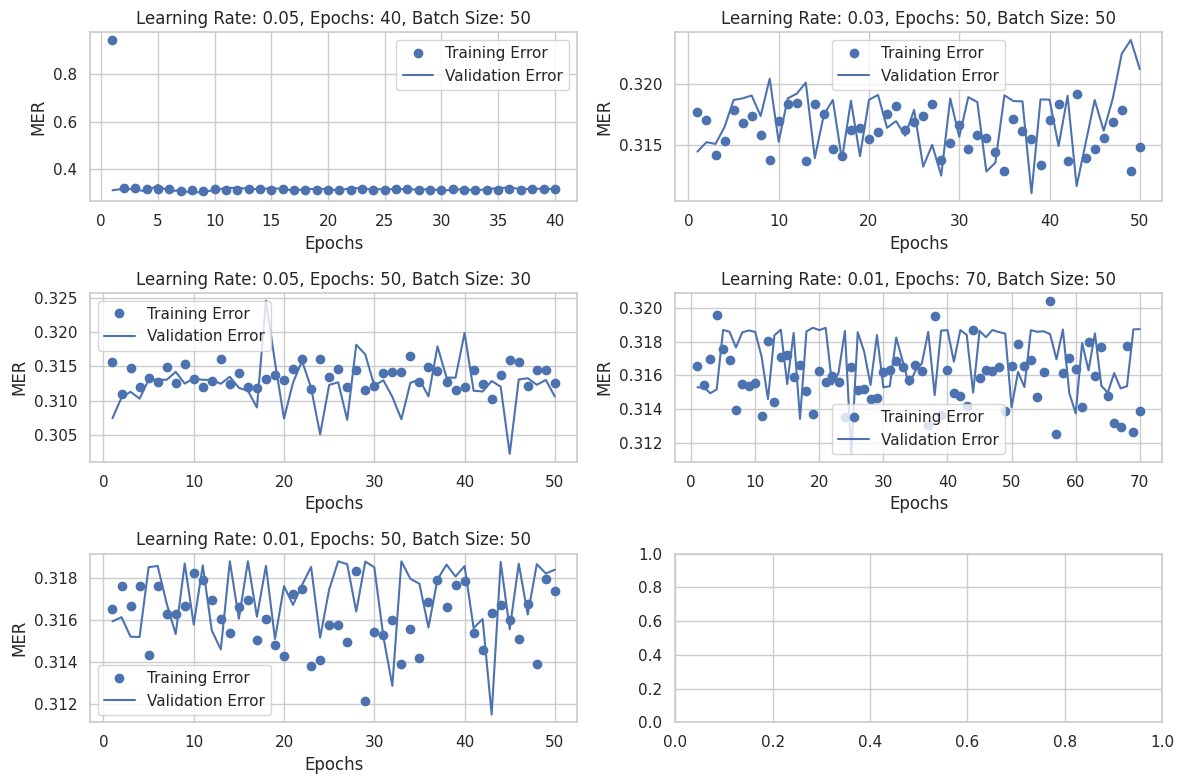

In [34]:
#code to plot the training error (MER) over epochs
import matplotlib.pyplot as plt

# Create a figure with four subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()

# Plot the training and validation errors for each hyperparameter combination
for i, (train_errors, val_errors, result) in enumerate(zip(train_errors_list, val_errors_list, results)):
    ax = axs[i]
    epochs = range(1, len(train_errors) + 1)

    ax.plot(epochs, train_errors, 'bo', label='Training Error')
    ax.plot(epochs, val_errors, 'b', label='Validation Error')

    ax.set_title(f"Learning Rate: {result[0]}, Epochs: {result[1]}, Batch Size: {result[2]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MER")
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

**Question 3**: What are your final training and validation errors of the third multilayer perception model?

In [35]:
# Print the results
print("Learning Rate | Epochs | Batch Size | Train Error | Validation Error")
print("----------------------------------------------------------------")
for result in results:
    print(f"{result[0]:.3f}         | {result[1]:6d} | {result[2]:10d} | {result[3]:.4f}      | {result[4]:.4f}")

Learning Rate | Epochs | Batch Size | Train Error | Validation Error
----------------------------------------------------------------
0.050         |     40 |         50 | 0.3178      | 0.3298
0.030         |     50 |         50 | 0.3193      | 0.3274
0.050         |     50 |         30 | 0.3137      | 0.3357
0.010         |     70 |         50 | 0.3165      | 0.3299
0.010         |     50 |         50 | 0.3135      | 0.3349
0.050         |     40 |         50 | 0.3174      | 0.3327
0.030         |     50 |         50 | 0.3148      | 0.3413
0.050         |     50 |         30 | 0.3126      | 0.3275
0.010         |     70 |         50 | 0.3139      | 0.3338
0.010         |     50 |         50 | 0.3174      | 0.3321


---
## Predict with the best model.

Modify the python code we used in class to
use the ModelCheckpoint callback to save the best model parameter values while training model 3 above. Then predict with this best model.  

In [ ]:
######################################################
## Let’s predict with the best model baed on model 3
def create_model():
  model3 = keras.models.Sequential()
  model3.add(keras.layers.Dense(512, input_shape=(p,), activation="relu"))
  model3.add(keras.layers.Dropout(0.2))
  model3.add(keras.layers.Dense(256, activation="relu"))
  model3.add(keras.layers.Dropout(0.2))
  model3.add(keras.layers.Dense(128, activation="relu"))
  model3.add(keras.layers.Dense(64, activation="relu"))
  model3.add(keras.layers.Dense(1, activation="linear"))
  model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss="mae", metrics=[median_error_rate])
  return model3

model=create_model()
model.summary()

checkpoint_dir = "checkpoints"
import os
try:
    os.mkdir(checkpoint_dir)
except:
    pass

filename = "weights-best-model.hdf7"
#filename = "weights-{epoch:03d}-{val_mse:.4f}.hdf5"
filepath = os.path.join(checkpoint_dir, filename)
checkpointer = keras.callbacks.ModelCheckpoint(filepath,
                                               monitor='val_median_error_rate',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='auto')

history = model.fit(train_features, train_labels, epochs = 100,
                    batch_size=100, validation_split=0.2,
                    callbacks=[checkpointer])

print(os.listdir(checkpoint_dir))






Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               52736     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 1)                

---
## Inference on validation data

After the MLP model is trained, we can use it for inference.

In [ ]:
## load the saved weights for the best model
model.load_weights(os.path.join(checkpoint_dir,'weights-best-model.hdf7'))
score=model.evaluate(valid_features,valid_labels)
print(score)


73/73 [==============================] - 0s 3ms/step - loss: 0.7892 - median_error_rate: 0.1070
[0.7891821265220642, 0.10702092200517654]


Let's first compute the predicted prices on the valid data. Remember when predict the price, we need to multiply back the normalization factor.

In [ ]:
#To do: calculate the predicted values on the validation data set
valid_predictions=model.predict(valid_features)*normalization_factor
valid_predictions


73/73 [==============================] - 0s 3ms/step


array([[550448.03619385],
       [581245.08857727],
       [314803.91025543],
       ...,
       [736183.35723877],
       [509591.67480469],
       [265585.89935303]])

Then we compute the validation errors using the error measure "median_error_rate" we defined. Output the median error rate on validation data.

In [ ]:
#To do: calculate the median error rate on validation data. Please use the "median_error_rate" we defined previously.
valid_features = tf.cast(valid_features, dtype=tf.float32)
valid_predict = model.predict(valid_features)
valid_predict = valid_predict.reshape(-1)

# Convert valid_labels to a NumPy array
valid_labels_np = valid_labels.values

error_rate = median_error_rate(valid_labels_np, valid_predict)
print('The validation error is', error_rate)

73/73 [==============================] - 0s 3ms/step
The validation error is tf.Tensor(0.09913371026652397, shape=(), dtype=float64)


# Profit Analysis

In [ ]:
valid_predict

array([5.5044804, 5.812451 , 3.148039 , ..., 7.3618336, 5.0959167,
       2.655859 ], dtype=float32)

In [ ]:
# Assumptions
purchase_discount = 0.05
expenses_ratio = 0.10
sale_premium = 0.10

total_profit = 0
for price in valid_predict * normalization_factor:  # Multiply by normalization_factor
    purchase_price = price * (1 - purchase_discount)
    expenses = price * expenses_ratio
    sale_price = price * (1 + sale_premium)

    profit = sale_price - purchase_price - expenses
    total_profit += profit

print(f"Total Profit: ${total_profit:,.2f}")

Total Profit: $55,864,474.30


In [ ]:
avg_profit_per_property = total_profit / len(valid_predict)
print(f"Average Profit per Property: ${avg_profit_per_property:,.2f}")

total_sale_price = sum(price * (1 + sale_premium) for price in valid_predict * normalization_factor)
profit_margin = total_profit / total_sale_price
print(f"Profit Margin: {profit_margin:.2%}")

num_profitable_transactions = sum(1 for price in valid_predict * normalization_factor if price * (1 + sale_premium) > price * (1 - purchase_discount) + price * expenses_ratio)
print(f"Number of Profitable Transactions: {num_profitable_transactions}")

Average Profit per Property: $24,110.69
Profit Margin: 4.55%
Number of Profitable Transactions: 2317
